# Checking impact of salinity restoring relative to meltwater perturbation

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
from gsw import SA_from_SP, p_from_z

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

#figdir = '/g/data/v45/akm157/figures/IAF_meltwater/'

In [2]:
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44847,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:35865,Total threads: 1
Dashboard: /proxy/38681/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:33049,


2025-10-21 11:54:15,734 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('rechunk-merge-382d15c764c5431790ddae89327e3cc0', 2, 16) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: Alias(('rechunk-merge-382d15c764c5431790ddae89327e3cc0', 2, 16)->('rechunk-split-rechunk-merge-rechunk-merge-382d15c764c5431790ddae89327e3cc0', 2, 16))
new run_spec: Alias(('rechunk-merge-382d15c764c5431790ddae89327e3cc0', 2, 16)->('rechunk-split-rechunk-merge-382d15c764c5431790ddae89327e3cc0', 2, 16))
old token: ('5792a51a3c615ecd', [])
new token: ('4c3e97fac7aba165', [])
old dependencies: {('rechunk-split-rechunk-merge-re

In [3]:
# Importing the data
db = '/home/272/kc5856/databases/honours_prescribed.db'
session = cc.database.create_session(db)

control = '01deg_jra55v13_ryf9091_21mbath'
ACC_melt = '01deg_jra55v13_ryf9091_21mbath_sofia_ssp126_prsc_rest'

start_time='1910-01-01'
end_time='1919-12-31'

lat_slice  = slice(-80,-59)

In [4]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
#land_mask_lat = ht.yt_ocean.values
#land_mask_lat[0] = -90

fontsize=15

### Time series of restoring over shelf

In [5]:
# shelf masking:
contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
shelf_mask = contour_file['contour_masked_above']
yt_ocean = contour_file['yt_ocean'] #slice to match lat_slice
xt_ocean = contour_file['xt_ocean']
# Mask values that are non-zero
shelf_mask[np.where(shelf_mask!=0)] = np.nan
shelf_mask = shelf_mask+1
shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])

In [6]:
# Area
area_old = cc.querying.getvar(control, 'area_t', session,n=1).sel(yt_ocean=lat_slice)

# Getting variable
var = cc.querying.getvar(control,'salt', session,n=1).isel(time=0,st_ocean=0).load()

# Correcting area
area_t = area_old*(var*0 +1)

area_t = (area_t*shelf_mask).load()
area_sum = area_t.sum(dim={'xt_ocean','yt_ocean'}).load()

In [7]:
# stuff needed for absolute salinity conversion:
st_ocean = cc.querying.getvar(control,'st_ocean', session,n=1).load()
geolon_t = cc.querying.getvar(control,'geolon_t',session, n=1).sel(yt_ocean=lat_slice).load()
geolat_t = cc.querying.getvar(control,'geolat_t',session, n=1).sel(yt_ocean=lat_slice).load()
depth_tile = -(geolat_t*0+1)*st_ocean[0].values
pressure = xr.DataArray(p_from_z(depth_tile,geolat_t), coords = [yt_ocean[27:510], xt_ocean], dims = ['yt_ocean', 'xt_ocean'], 
                        name = 'pressure', attrs = {'units':'dbar'}) #slice to match lat_slice

In [8]:
SSS_prac = cc.querying.getvar(control, 'salt', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
SSS_prac = SSS_prac.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(st_ocean=0,method='nearest')

# convert units to absolute salinity:
SSS_con = xr.DataArray(SA_from_SP(SSS_prac,pressure,geolon_t,geolat_t), coords = [SSS_prac.time, SSS_prac.yt_ocean, SSS_prac.xt_ocean], 
                       dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', 
                       attrs = {'units':'Absolute Salinity (g/kg)'})

In [9]:
salt_flux_ice_con = cc.querying.getvar(control, 'sfc_salt_flux_ice', session, frequency='1 monthly',
                                   start_time=start_time, end_time=end_time)

salt_flux_ice_con = salt_flux_ice_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
salt_flux_ice_con = -salt_flux_ice_con*1000/SSS_con # negative sign makes this a salt -> FW flux conversion
salt_flux_ice_con.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/flux_ice_con_prescribed_access.nc')

In [9]:
pme_river_con = cc.querying.getvar(control, 'pme_river', session, frequency='1 monthly',
                                   start_time=start_time, end_time=end_time)

pme_river_con = -(pme_river_con*SSS_con)/1000
pme_river_con = pme_river_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# need factor of 1000, because salt flux is in (kg of salt)/m^2/s, but SSS is in (g salt)/(kg of water)
pme_river_con = pme_river_con*1000/SSS_con
pme_river_con.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/pme_river_salt_con_prescribed_access.nc')

In [9]:
restoring_con = cc.querying.getvar(control, 'sfc_salt_flux_restore', session, frequency='1 monthly',
                                   start_time=start_time, end_time=end_time)
restoring_con = restoring_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# need factor of 1000, because salt flux is in (kg of salt)/m^2/s, but SSS is in (g salt)/(kg of water)
restoring_con = restoring_con*1000/SSS_con
restoring_con.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/restoring_con_prescribed_access.nc')

In [10]:
# restrict to shelf and integrate over area:
restoring_con = (restoring_con*area_t).sum('xt_ocean').sum('yt_ocean')/area_sum
restoring_con = restoring_con.load()

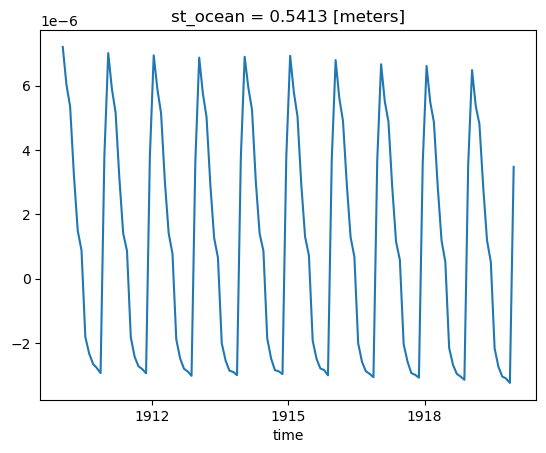

In [11]:
restoring_con.plot()

In [12]:
SSS_prac = cc.querying.getvar(ACC_melt, 'salt', session, frequency='1 monthly',start_time=start_time, end_time=end_time)
SSS_prac = SSS_prac.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(st_ocean=0,method='nearest')

# convert units to absolute salinity:
SSS_melt = xr.DataArray(SA_from_SP(SSS_prac,pressure,geolon_t,geolat_t), coords = [SSS_prac.time, SSS_prac.yt_ocean, SSS_prac.xt_ocean], 
                       dims = ['time','yt_ocean', 'xt_ocean'], name = 'sea surface salinity', 
                       attrs = {'units':'Absolute Salinity (g/kg)'})

In [11]:
salt_flux_ice_melt = cc.querying.getvar(ACC_melt, 'sfc_salt_flux_ice', session, frequency='1 monthly',
                                   start_time=start_time, end_time=end_time)

salt_flux_ice_melt = salt_flux_ice_melt.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
salt_flux_ice_melt = -salt_flux_ice_melt*1000/SSS_melt # negative sign makes this a salt -> FW flux conversion
salt_flux_ice_melt.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/flux_ice_melt_prescribed_access.nc')

2025-10-14 21:26:06,139 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/comm/tcp.py", line 225, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/worker.py", line 1269, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/utils_comm.py", line 441, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/g/d

In [12]:
pme_river_melt = cc.querying.getvar(ACC_melt, 'pme_river', session, frequency='1 monthly',
                                   start_time=start_time, end_time=end_time)

pme_river_melt = -(pme_river_melt*SSS_melt)/1000
pme_river_melt = pme_river_melt.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# need factor of 1000, because salt flux is in (kg of salt)/m^2/s, but SSS is in (g salt)/(kg of water)
pme_river_melt = pme_river_melt*1000/SSS_melt
pme_river_melt.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/pme_river_salt_melt_prescribed_access.nc')

Up to here - need to grab pme_correct and convert it to a salt flux.

We know: FWF = -salt flux*1000/SSS

therefore 

`pme_correct` = -`salt_flux`*1000/`SSS_melt`

so rearranging gives

`salt_flux` = -(`pme_correct`*`SSS_melt`)/1000

In [13]:
pme_correct = cc.querying.getvar(ACC_melt, 'pme_correct', session, frequency='1 monthly',
                                   start_time='1909-01-01', end_time=end_time)

restoring_correct_melt = -(pme_correct*SSS_melt)/1000

restoring_correct_melt = restoring_correct_melt.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# need factor of 1000, because salt flux is in (kg of salt)/m^2/s, but SSS is in (g salt)/(kg of water)
restoring_correct_melt = restoring_correct_melt*1000/SSS_con # using con instead of SSS_melt
restoring_correct_melt.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/restoring_correct_melt_prescribed_access.nc')

In [ ]:
# restrict to shelf and integrate over area:
restoring_correct_melt = (restoring_correct_melt*area_t).sum('xt_ocean').sum('yt_ocean')/area_sum
restoring_correct_melt = restoring_correct_melt.load()

Using `runoff`:

In [ ]:
# compare to runoff:

runoff_con = cc.querying.getvar(control, 'runoff', session, frequency='1 monthly',
                                   start_time=start_time, end_time=end_time)
runoff_con = runoff_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# restrict to shelf and integrate over area:
runoff_con = (runoff_con*area_t).sum('xt_ocean').sum('yt_ocean')/area_sum
runoff_con = runoff_con.load()

runoff_melt = cc.querying.getvar(ACC_melt, 'runoff', session, frequency='1 monthly',
                                   start_time=start_time, end_time=end_time)
runoff_melt = runoff_melt.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
# restrict to shelf and integrate over area:
runoff_melt = (runoff_melt*area_t).sum('xt_ocean').sum('yt_ocean')/area_sum
runoff_melt = runoff_melt.load()

In [ ]:
# units of both should be (kg of water)/m^2/s averaged over the shelf:

plt.figure(figsize=(14,7))
(runoff_melt - runoff_con).plot(label='runoff perturbation')
((runoff_melt - runoff_con)-(restoring_correct_melt - restoring_con)).plot(label='runoff minus restoring change')
((restoring_correct_melt - restoring_con)).plot(label='restoring change')
plt.legend()
plt.ylabel('Freshwater flux equivalent ((kg of water)/m^2/s)')
plt.title('Runoff and restoring integrated over shelf (new)')
#plt.ylim(0,2.1e-6)

Text(0.5, 1.0, 'Runoff and restoring integrated over shelf')

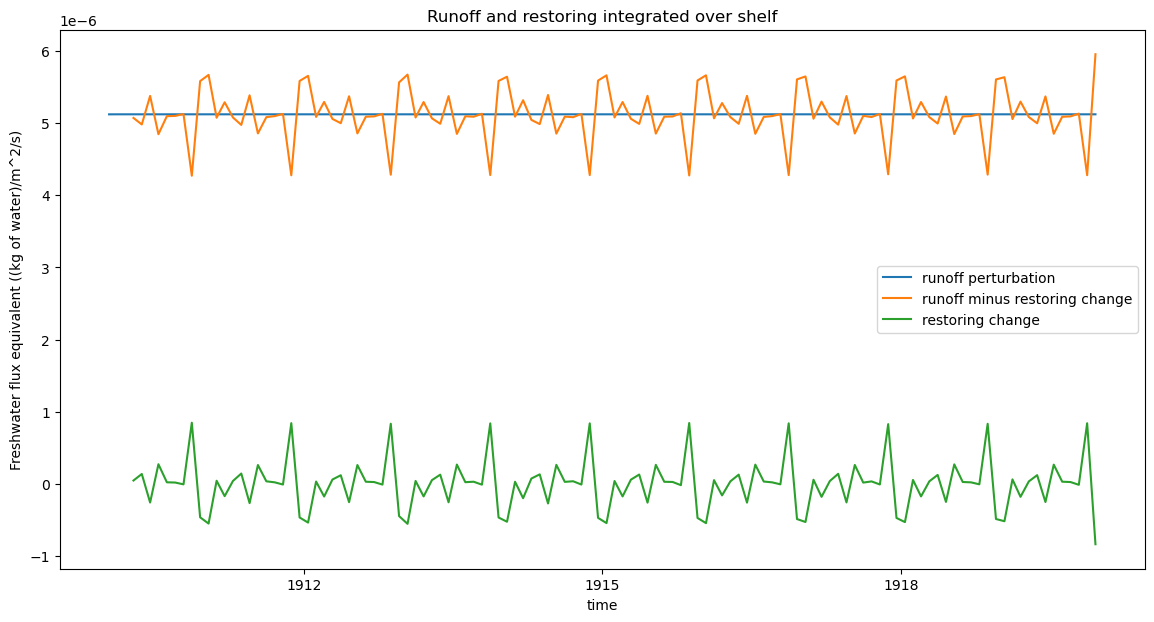

In [15]:
# units of both should be (kg of water)/m^2/s averaged over the shelf:

plt.figure(figsize=(14,7))
(runoff_melt - runoff_con).plot(label='runoff perturbation')
((runoff_melt - runoff_con)-(restoring_correct_melt - restoring_con)).plot(label='runoff minus restoring change')
((restoring_correct_melt - restoring_con)).plot(label='restoring change')
plt.legend()
plt.ylabel('Freshwater flux equivalent ((kg of water)/m^2/s)')
plt.title('Runoff and restoring integrated over shelf')
#plt.ylim(0,2.1e-6)

**Interpretation:**  
Small difference → restoring NOT removing much meltwater effect → perturbation signal preserved.  
Large difference → restoring IS removing meltwater effect → perturbation signal masked.  

In [ ]:
runoff_pert = (runoff_melt - runoff_con)
runoff_minus_restoring_change = (runoff_melt - runoff_con) - (restoring_correct_melt - restoring_con)
restoring_change = (restoring_correct_melt - restoring_con)

In [ ]:
runoff_pert.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/runoff_pert_prescribed_access.nc')
runoff_minus_restoring_change.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/runoff_minus_restoring_change_prescribed_access.nc')
restoring_change.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/restoring_change_prescribed_access.nc')